# Analyzing CIA Factbook Data Using SQLite and Python

Data from the CIA World Factbook, a compendium of statistics about all of the countries on Earth. Link: https://www.cia.gov/library/publications/the-world-factbook/ . The Factbook contains demographic information like:
- population - The population as of 2015.
- population_growth - The annual population growth rate, as a percentage.
- area - The total land and water area.

Goal: with the typical Python SQLite workflow explore, analyze, and visualize data from this db.

### First exploration

In [5]:
import sqlite3
import pandas as pd

conn = sqlite3.connect("factbook.db")

# returns information on the tables in the database
q = "SELECT * FROM sqlite_master WHERE type='table';"
pd.read_sql_query(q, conn)

,type,name,tbl_name,rootpage,sql
0,table,sqlite_sequence,sqlite_sequence,3,"CREATE TABLE sqlite_sequence(name,seq)"
1,table,facts,facts,47,"CREATE TABLE ""facts"" (""id"" INTEGER PRIMARY KEY..."


In [6]:
# returns the first 5 rows of the facts table
q1 = "SELECT * FROM facts LIMIT 5"
cursor = conn.cursor()
cursor.execute(q1).fetchall()

[(1,
  'af',
  'Afghanistan',
  652230,
  652230,
  0,
  32564342,
  2.32,
  38.57,
  13.89,
  1.51),
 (2, 'al', 'Albania', 28748, 27398, 1350, 3029278, 0.3, 12.92, 6.58, 3.3),
 (3, 'ag', 'Algeria', 2381741, 2381741, 0, 39542166, 1.84, 23.67, 4.31, 0.92),
 (4, 'an', 'Andorra', 468, 468, 0, 85580, 0.12, 8.13, 6.96, 0.0),
 (5, 'ao', 'Angola', 1246700, 1246700, 0, 19625353, 2.78, 38.78, 11.49, 0.46)]

In [7]:
# same query but with the pands.read_sql_query() method:
pd.read_sql_query(q1, conn)

,id,code,name,area,area_land,area_water,population,population_growth,birth_rate,death_rate,migration_rate
0,1,af,Afghanistan,652230,652230,0,32564342,2.32,38.57,13.89,1.51
1,2,al,Albania,28748,27398,1350,3029278,0.30,12.92,6.58,3.30
2,3,ag,Algeria,2381741,2381741,0,39542166,1.84,23.67,4.31,0.92
3,4,an,Andorra,468,468,0,85580,0.12,8.13,6.96,0.00
4,5,ao,Angola,1246700,1246700,0,19625353,2.78,38.78,11.49,0.46


##### Descriptions for some of the columns:
- name - The name of the country.
- area - The total land and sea area of the country.
- population - The country's population.
- population_growth- The country's population growth as a percentage.
- birth_rate - The country's birth rate, or the number of births a year per 1,000 people.
- death_rate - The country's death rate, or the number of death a year per 1,000 people.
- area- The country's total area (both land and water).
- area_land - The country's land area in square kilometers.
- area_water - The country's waterarea in square kilometers.

### Summary statistics

In [8]:
# returns min & max for the following columns: population, population growth
q2 = """
SELECT MIN(population) AS min_population, MAX(population) AS max_population, 
       MIN(population_growth) AS min_population_growth, MAX(population_growth) AS max_population_growth 
FROM facts;
"""       
pd.read_sql_query(q2, conn)

,min_population,max_population,min_population_growth,max_population_growth
0,0,7256490011,0.0,4.02


There is a country with no one, and another country with more than 7 billions people which is roughly the total amount of humans on earth... those values are not possible.

### Outliers - irrelevant values

In [9]:
# returns the countrie(s) with a population of 0
q3 = "SELECT name, population FROM facts WHERE population = (SELECT MIN(population) FROM facts);"
pd.read_sql_query(q3, conn)

,name,population
0,Antarctica,0


In [10]:
# returns the countrie(s) with the max population
q4 = "SELECT name, population FROM facts WHERE population = (SELECT MAX(population) FROM facts);"
pd.read_sql_query(q4, conn)

,name,population
0,World,7256490011


The table contains a row for Antarctica and a row for the whole world, which explains the populations of 0 and of over 7.2 billion. This is explained in the CIA Factbook page for Antarctica: https://www.cia.gov/library/publications/the-world-factbook/geos/ay.html

### Histograms for the rest of the countries

In [11]:
# returns all of the values we want to visualize except the 2 mentionned above
q5 = """
SELECT population, population_growth, birth_rate, death_rate
FROM facts
WHERE (population > (SELECT MIN(population) FROM facts)) AND 
      (population < (SELECT MAX(population) FROM facts));
"""
result_df = pd.read_sql_query(q5, conn)

/dataquest/system/env/python3/lib/python3.4/site-packages/IPython/core/interactiveshell.py:2885: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  exec(code_obj, self.user_global_ns, self.user_ns)


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f65107fd7f0>,
      dtype=object)

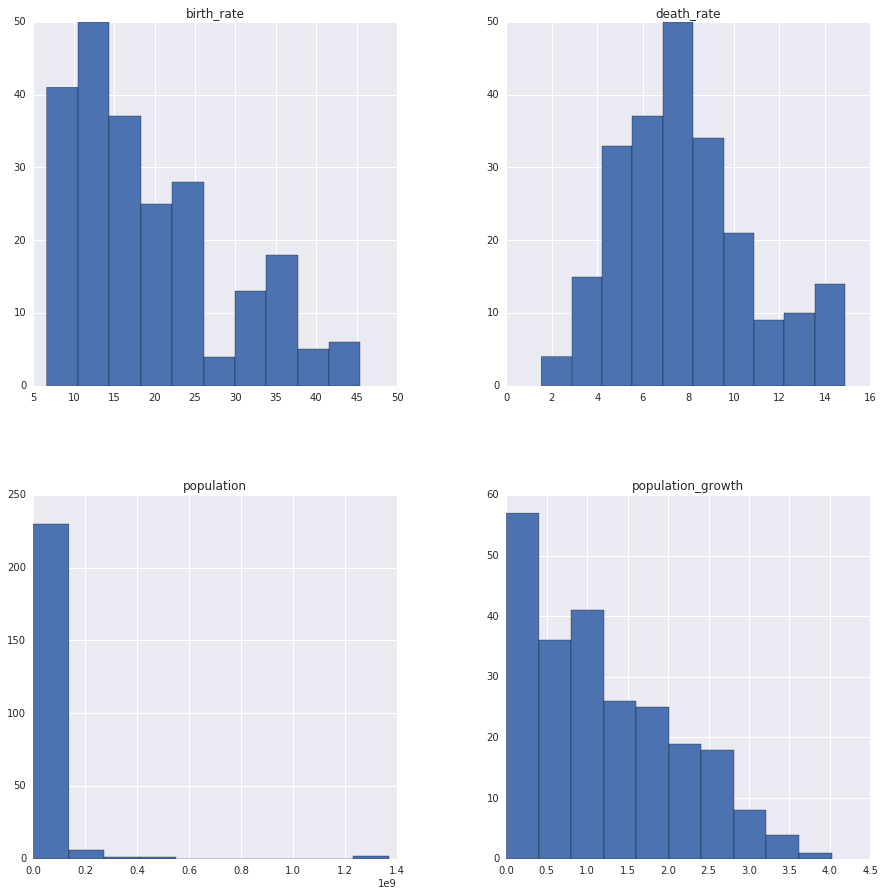

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111)     # 4 subplots 2x2
result_df.hist(ax=ax)

### Further investigations
- Which countries have the highest population density? (ratio of population to land area)
- Generate a histogram of population densities.
- Which countries have the highest ratios of water to land? Which countries have more water than land?

In [22]:
# returns the top 10 countries with the highest density
q6 = """
SELECT name, population, area, CAST(population as float) / CAST(area as float) AS pop_density
FROM facts
ORDER BY pop_density DESC
LIMIT 10;
"""
density_df = pd.read_sql_query(q6, conn)
print(density_df)

         name  population  area   pop_density
0       Macau      592731    28  21168.964286
1      Monaco       30535     2  15267.500000
2   Singapore     5674472   697   8141.279770
3   Hong Kong     7141106  1108   6445.041516
4  Gaza Strip     1869055   360   5191.819444
5   Gibraltar       29258     6   4876.333333
6     Bahrain     1346613   760   1771.859211
7    Maldives      393253   298   1319.640940
8       Malta      413965   316   1310.015823
9     Bermuda       70196    54   1299.925926


##### Many of the countries with the highest density have in fact small areas, which explains the values.

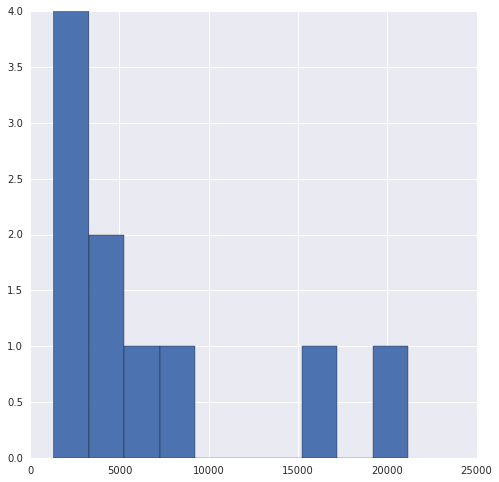

In [30]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)     # 4 subplots 2x2
density_df['pop_density'].hist(ax=ax)

In [29]:
# returns countries with the highest ratios of water to land
q7 = """
SELECT name, area, area_water, CAST(area_water as float) / CAST(area as float) AS water_ratio
FROM facts
ORDER BY water_ratio DESC
LIMIT 10;
"""
pd.read_sql_query(q7, conn)

,name,area,area_water,water_ratio
0,British Indian Ocean Territory,54400,54340,0.998897
1,Virgin Islands,1910,1564,0.818848
2,Puerto Rico,13791,4921,0.356827
3,"Bahamas, The",13880,3870,0.278818
4,Guinea-Bissau,36125,8005,0.221592
5,Malawi,118484,24404,0.205969
6,Netherlands,41543,7650,0.184147
7,Uganda,241038,43938,0.182287
8,Eritrea,117600,16600,0.141156
9,Liberia,111369,15049,0.135127


In [31]:
# returns countries with more water than land
q8 = """
SELECT name, area_land, area_water
FROM facts
WHERE area_water > area_land
ORDER BY (SELECT CAST(area_water as float) / CAST(area_land as float) FROM facts) DESC
"""
pd.read_sql_query(q8, conn)

,name,area_land,area_water
0,British Indian Ocean Territory,60,54340
1,Virgin Islands,346,1564


##### There are two countries 